In [1]:
import os
import pandas as pd
import numpy as np
import gzip
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from article_dataset import ArticleDataset

from transformers import BertForSequenceClassification


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import BertTokenizerFast as BertTokenizer

In [4]:
LABEL = 'major_topic_pred_index'
ARTICLE = 'article'

In [5]:
def read_folder(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jsonl.gz'):
            with gzip.open(os.path.join(folder_path, filename), 'rt', encoding='utf-8') as file:
                for line in file:
                    json_data = json.loads(line)
                    df = pd.DataFrame(json_data)
                    dataframes.append(df)
    if dataframes:
        aggregated_df = pd.concat(dataframes, ignore_index=True)
        return aggregated_df
    else:
        print("No jsonl files found in the directory.")
        return None
    
def reduce(_number=6):
    # csak a test
    test = os.path.join(os.getcwd(), 'test')
    df = read_folder(test)
    df.drop('uuid', axis=1, inplace=True)
    return df.groupby('major_topic_pred').apply(lambda x: x.sample(n=min(_number, len(x)))).reset_index(drop=True)


df_train = reduce(6)
df_test = reduce(3)
df_eval = reduce(3)

print(df_train.index)
print(df_test.index)
print(df_eval.index)

labels = df_train['major_topic_pred'].unique().tolist()
number_of_labels = len(labels)
id_to_label = {_id: label for _id, label in enumerate(labels)}
label_to_id = {label: _id for _id, label in enumerate(labels)}


df_train["major_topic_pred_index"] = df_train['major_topic_pred'].map(lambda x: label_to_id[x])
df_test["major_topic_pred_index"] = df_test['major_topic_pred'].map(lambda x: label_to_id[x])
df_eval["major_topic_pred_index"] = df_eval['major_topic_pred'].map(lambda x: label_to_id[x])

df_eval.info()

RangeIndex(start=0, stop=132, step=1)
RangeIndex(start=0, stop=66, step=1)
RangeIndex(start=0, stop=66, step=1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   66 non-null     object 
 1   lead                    66 non-null     object 
 2   article                 66 non-null     object 
 3   domain                  66 non-null     object 
 4   url                     66 non-null     object 
 5   date_of_creation        65 non-null     object 
 6   cc_date                 66 non-null     object 
 7   tags                    66 non-null     object 
 8   doc_similarity          66 non-null     float64
 9   major_topic_pred        66 non-null     int64  
 10  major_topic_pred_index  66 non-null     int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 5.8+ KB


In [6]:
df_train.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Adóegyezmények tartják itt az offshore cégeket,Noha az év elején megszűnik az offshore státus...,Voltaképpen nem uniós ügy az offshore cégek ad...,index.hu,https://index.hu/gazdasag/magyar/off051228/,2005-12-28T08:00:00,2017-12-15T06:34:55,gazdasag,0.563389,1,0
1,Saját hajánál fogva húzta ki magát a H&M a baj...,16 év óta most nőttek a legintenzívebben a Hen...,"A H&M részvényei 11 százalékot lengtek ki, 2 m...",hvg.hu,https://hvg.hu/kkv/20180917_Sajat_hajanal_fogv...,2018-09-17T13:09:00,2021-05-17T03:20:24,H&M,0.661749,1,0
2,Gyenge teljesítmény a francia ipari óriástól,A cég nettó nyeresége március 31-ével zárult ü...,A cég nettó nyeresége március 31-ével zárult ü...,hvg.hu,https://hvg.hu/kkv/20110504_alstom/nyomtatas,2011-05-04T12:06:00,2021-02-28T21:06:29,osztalék,0.867125,1,0
3,Tarolnak a Suzuki autói Indiában,A vártnál jobb elsõ féléves eredmények közzété...,A Magyarországon is gyártó Suzuki Motor az els...,origo.hu,https://www.origo.hu/gazdasag/20091102-vartnal...,2009-11-02T13:29:00,2019-08-21T02:03:16,gazdasági válság,0.701018,1,0
4,"Aki hátralép, veszíthet... – Szijjártó Péter n...","„Az útépítések, a digitális infrastruktúra fej...",Egyebek mellett erről is beszélt lapunknak teg...,zaol.hu,https://www.zaol.hu/gazdasag/aki-hatralep-vesz...,2018-04-07T08:00:00,2020-08-08T17:56:29,autóipar,0.559537,1,0


In [7]:
df_test.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Nem várható kamatcsökkentés egy sikeres IMF-me...,Az inflációs nyomás miatt akkor sem várható gy...,"Az egyik vezetõ londoni pénzügyi elemzõház, a ...",delmagyar.hu,http://www.delmagyar.hu/belfold_hirek/nem_varh...,2012-04-24T18:13:00,2017-03-28T04:51:07,IMF,0.594582,1,0
1,Az üzleti szféra üzenete Orbánnak: első a gazd...,A gazdasági érdekvédelmi szervezetek vezetői m...,"Legelőször is a gazdaságot kell rendbe hozni, ...",hvg.hu,https://hvg.hu/gazdasag/20100510_uzleti_szfera...,2010-05-11T06:30:00,2020-08-05T22:42:30,MKIK,0.560493,1,0
2,Felszabaduló nyugdíjpénzek,Az idén 180 ezer önkéntes nyugdíjpénztári tag ...,A személyi jövedelemadó összevont alapjába szá...,index.hu,https://index.hu/gazdasag/magyar/nyugd050111/,2005-01-11T16:45:00,2018-01-21T17:12:46,Magyar,0.779033,1,0
3,Lecigányozzák az utcán Béci párját a VV-sztár ...,"Béci párja, Adrienn zaklatásnak van kitéve.","A lány nemrég elárulta, már a buszon is lecigá...",kisalfold.hu,http://www.kisalfold.hu/szorakozas/leciganyozz...,2011-03-11T09:45:00,2017-03-26T12:12:27,bulvárketrec,0.405999,2,1
4,Megütötték a meleg büszkeség egyik résztvevőjét,Szélsőjobboldali csoportok zavarták meg vasárn...,"Vasárnap este hét óra körül, a Budapest Pride ...",index.hu,http://index.hu/belfold/2010/07/05/megutottek_...,2010-07-05T12:42:00,2017-11-23T00:44:56,Belföld,0.823498,2,1


In [8]:
df_eval.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Idén több tízezer dollármilliomos költözhet má...,Az idei év jelentős mozgásokat hozhat a világb...,Az idei évben 88 ezer dollármilliomos magánsze...,origo.hu,https://www.origo.hu/gazdasag/20220627-milliom...,2022-07-03T17:47:00,2022-08-08T10:30:39,ország,0.634726,1,0
1,A férfiak és a nem vallásosak elégedetlenek a ...,"A pártot választók körében a Fideszre ötven, a...",A két nagy párt támogatottságának különbsége m...,index.hu,https://index.hu/belfold/gallfm0317/,2005-03-17T21:24:00,2018-03-19T13:49:25,Belföld,0.761128,1,0
2,Élre tört az ásványvíz,Majdnem megháromszorozódott azok száma az elmú...,"Az ásványvíz a legnépszerűbb szomjoltó ital, a...",index.hu,http://index.hu/gazdasag/magyar/udito030805/,2003-08-05T14:50:00,2017-06-24T22:49:46,gazdasag,0.897586,1,0
3,Anonymous: sokba fájhat a fenyegetőzés,Egyelőre nem tapasztalt nagyobb ellenséges akt...,Bár nagyon határozottnak tűnt az Anonymous vid...,hvg.hu,https://hvg.hu/itthon/20151229_Anonymous_sokba...,2015-12-29T12:45:00,2021-06-21T20:13:12,Nemzeti Kibervédelmi Intézet,0.746441,2,1
4,A náci kirakatper a nemzetközi jogot is átírta,"Egészen pontosan hetven éve, 1945. november 20...","Az, hogy a náci Németország vezetői bíróság el...",index.hu,https://index.hu/tudomany/tortenelem/2015/11/2...,2015-11-20T07:55:00,2018-03-18T04:40:02,nürnbergi mesterdalnokok,0.642804,2,1


In [9]:
id_to_label, label_to_id

({0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 12,
  11: 13,
  12: 14,
  13: 15,
  14: 16,
  15: 17,
  16: 18,
  17: 19,
  18: 20,
  19: 21,
  20: 23,
  21: 999},
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  12: 10,
  13: 11,
  14: 12,
  15: 13,
  16: 14,
  17: 15,
  18: 16,
  19: 17,
  20: 18,
  21: 19,
  23: 20,
  999: 21})

In [10]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, return_tensors='pt')

In [11]:
sample_row = df_train.iloc[0]
sample_article = sample_row[ARTICLE]
sample_label = sample_row[LABEL]

print(sample_article)
print("label: ", sample_label)

Voltaképpen nem uniós ügy az offshore cégek adóterhein (is) jelentősen könnyítő, a kamatjövedelmeket érintő 50 százalékos adókedvezmény kérdése. Magyarország - a többi uniós tagállammal együtt - az úgynevezett Code of Conduct (CoC) megállapodást írta alá, amelyben kötelezettséget vállalt arra, hogy távol tartja magát a káros adóversenyt generáló intézkedésektől - emlékeztet Erdős Gabriella, a PricewaterhouseCoopers adópartnere. A megállapodás példálózó felsorolással tartalmazza a káros intézkedések jellemzőit, így a szelektivitást is, ami a kamatjövedelmekre vonatkozó magyarországi adókedvezménnyel kapcsolatban felmerülhet a CoC ellenőrző bizottsága szerint - írja a Napi Gazdaság.

A kedvezmény ugyanis jóval többet hozhat a jellemzően kamatjövedelemmel bíró ágazatok, illetve társaságok - mint például a vállalatfinanszírozással foglalkozó cégek - konyhájára, mint a többi gazdálkodó esetében. A testület egyelőre mindössze azt jelezte, hogy felvenné a kérdést az ellenőrizendő ügyek listáj

In [12]:
encoding = tokenizer.encode_plus(
  sample_article,
  add_special_tokens=True,
  max_length=1024,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 1565]), torch.Size([1, 1565]))

In [14]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'volta', '##ke', '##ppe', '##n', 'ne', '##m', 'un', '##ios', 'u', '##gy', 'az', 'offshore', 'ce', '##ge', '##k', 'ad', '##ote', '##rh', '##ein']


In [15]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row[ARTICLE], 
        max_length=512, 
        truncation=True
    ))
    token_counts.append(token_count)

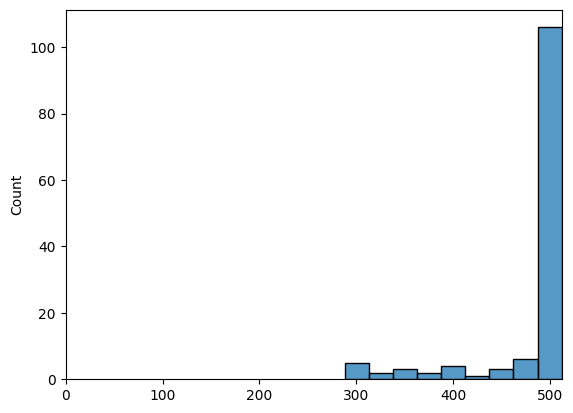

In [16]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [17]:
MAX_TOKEN_COUNT = 512

In [18]:


train_dataset = ArticleDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['article', 'input_ids', 'attention_mask', 'label'])

In [19]:
sample_item

{'article': 'Voltaképpen nem uniós ügy az offshore cégek adóterhein (is) jelentősen könnyítő, a kamatjövedelmeket érintő 50 százalékos adókedvezmény kérdése. Magyarország - a többi uniós tagállammal együtt - az úgynevezett Code of Conduct (CoC) megállapodást írta alá, amelyben kötelezettséget vállalt arra, hogy távol tartja magát a káros adóversenyt generáló intézkedésektől - emlékeztet Erdős Gabriella, a PricewaterhouseCoopers adópartnere. A megállapodás példálózó felsorolással tartalmazza a káros intézkedések jellemzőit, így a szelektivitást is, ami a kamatjövedelmekre vonatkozó magyarországi adókedvezménnyel kapcsolatban felmerülhet a CoC ellenőrző bizottsága szerint - írja a Napi Gazdaság.\n\nA kedvezmény ugyanis jóval többet hozhat a jellemzően kamatjövedelemmel bíró ágazatok, illetve társaságok - mint például a vállalatfinanszírozással foglalkozó cégek - konyhájára, mint a többi gazdálkodó esetében. A testület egyelőre mindössze azt jelezte, hogy felvenné a kérdést az ellenőrizen

In [20]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 60

def create_dataloader(df, tokenizer, max_token_len, batch_size):
    dataset = ArticleDataset(
        df,
        tokenizer=tokenizer,
        max_token_len=max_token_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1
    )

In [21]:
data_loader_train = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_test = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_eval = create_dataloader(df_eval, tokenizer, MAX_LEN, BATCH_SIZE)

In [22]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, return_dict=True, num_labels=number_of_labels)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
accuracy_per_epoch = []
early_stopping_epochs = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_labels = 0
    prev_loss = np.inf
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        correct_labels += (logits.argmax(dim=1) == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if total_loss < prev_loss - 0.001:
        prev_loss = total_loss
        counter = 0
    else:
        counter += 1
        if counter >= early_stopping_epochs:
            print(f'Early stopping at epoch {epoch}')
            break
        

    accuacy = correct_labels / len(df_train)
    accuracy_per_epoch.append(accuacy)
    print(f"Epoch: {epoch}, Loss: {loss.item()} Accuracy: {accuacy}")

Epoch: 0, Loss: 3.3072643280029297 Accuracy: 0.030303030303030304
Epoch: 1, Loss: 3.1639840602874756 Accuracy: 0.03787878787878788
Epoch: 2, Loss: 2.8912103176116943 Accuracy: 0.03787878787878788
Epoch: 3, Loss: 2.947960615158081 Accuracy: 0.05303030303030303
Epoch: 4, Loss: 2.9297664165496826 Accuracy: 0.06060606060606061
Epoch: 5, Loss: 2.857534408569336 Accuracy: 0.09090909090909091
Epoch: 6, Loss: 2.770221710205078 Accuracy: 0.12121212121212122
Epoch: 7, Loss: 2.7214291095733643 Accuracy: 0.1590909090909091
Epoch: 8, Loss: 2.660367727279663 Accuracy: 0.11363636363636363
Epoch: 9, Loss: 2.7301244735717773 Accuracy: 0.12878787878787878
Epoch: 10, Loss: 2.4871344566345215 Accuracy: 0.21212121212121213
Epoch: 11, Loss: 2.301459789276123 Accuracy: 0.3181818181818182
Epoch: 12, Loss: 2.181849479675293 Accuracy: 0.3560606060606061
Epoch: 13, Loss: 2.040654182434082 Accuracy: 0.42424242424242425
Epoch: 14, Loss: 2.1250548362731934 Accuracy: 0.4015151515151515
Epoch: 15, Loss: 1.92335224151

In [24]:
accuracy_per_epoch

[0.030303030303030304,
 0.03787878787878788,
 0.03787878787878788,
 0.05303030303030303,
 0.06060606060606061,
 0.09090909090909091,
 0.12121212121212122,
 0.1590909090909091,
 0.11363636363636363,
 0.12878787878787878,
 0.21212121212121213,
 0.3181818181818182,
 0.3560606060606061,
 0.42424242424242425,
 0.4015151515151515,
 0.49242424242424243,
 0.5833333333333334,
 0.6212121212121212,
 0.553030303030303,
 0.6515151515151515,
 0.6666666666666666,
 0.7272727272727273,
 0.7272727272727273,
 0.7348484848484849,
 0.8106060606060606,
 0.8181818181818182,
 0.8181818181818182,
 0.8484848484848485,
 0.8787878787878788,
 0.8712121212121212,
 0.8787878787878788,
 0.9242424242424242,
 0.9015151515151515,
 0.9090909090909091,
 0.9545454545454546,
 0.9242424242424242,
 0.946969696969697,
 0.9696969696969697,
 0.9621212121212122,
 0.9696969696969697,
 0.9621212121212122,
 0.9621212121212122,
 0.9621212121212122,
 0.9621212121212122,
 0.9848484848484849,
 0.9772727272727273,
 0.9848484848484849,
 0

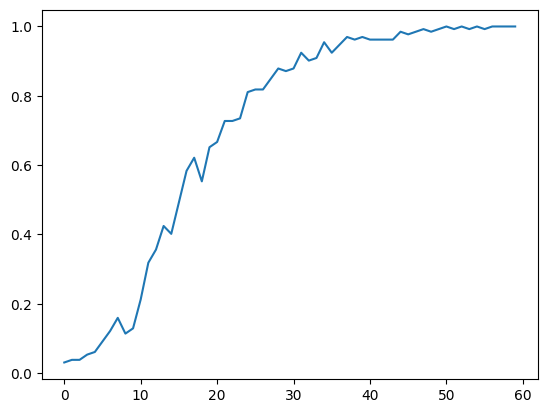

In [25]:
plt.plot(accuracy_per_epoch)

In [26]:
model.eval()
eval_loss = 0
correct_labels = 0

with torch.no_grad():
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        #print(f"{logits})")
        print(f"{logits.argmax(dim=1)} : {labels}")
        correct_labels += (logits.argmax(dim=1) == labels).sum().item()

tensor([0, 0, 0, 0, 0, 0, 1, 1]) : tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 1, 2, 2, 2, 2]) : tensor([1, 1, 1, 1, 2, 2, 2, 2])
tensor([2, 2, 3, 3, 3, 3, 3, 3]) : tensor([2, 2, 3, 3, 3, 3, 3, 3])
tensor([4, 4, 4, 4, 4, 4, 5, 5]) : tensor([4, 4, 4, 4, 4, 4, 5, 5])
tensor([5, 5, 5, 5, 6, 6, 6, 6]) : tensor([5, 5, 5, 5, 6, 6, 6, 6])
tensor([6, 6, 7, 7, 7, 7, 7, 7]) : tensor([6, 6, 7, 7, 7, 7, 7, 7])
tensor([8, 8, 8, 8, 8, 8, 9, 9]) : tensor([8, 8, 8, 8, 8, 8, 9, 9])
tensor([ 9,  9,  9,  9, 10, 10, 10, 10]) : tensor([ 9,  9,  9,  9, 10, 10, 10, 10])
tensor([10, 10, 11, 11, 11, 11, 11, 11]) : tensor([10, 10, 11, 11, 11, 11, 11, 11])
tensor([12, 12, 12, 12, 12, 12, 13, 13]) : tensor([12, 12, 12, 12, 12, 12, 13, 13])
tensor([13, 13, 13, 13, 14, 14, 14, 14]) : tensor([13, 13, 13, 13, 14, 14, 14, 14])
tensor([14, 14, 15, 15, 15, 15, 15, 15]) : tensor([14, 14, 15, 15, 15, 15, 15, 15])
tensor([16, 16, 16, 16, 16, 16, 17, 17]) : tensor([16, 16, 16, 16, 16, 16, 17, 17])
tensor([17, 17, 17, 

In [27]:
# Calculate evaluation metrics
eval_len = len(data_loader_train.dataset)
eval_loss /= eval_len
accuracy = correct_labels / eval_len

print(f"Evaluation Loss: {eval_loss}")
print(f"Accuracy: {accuracy}")

Evaluation Loss: 0.0410388663524028
Accuracy: 1.0


In [28]:
model_path = 'poltextlab-like-classification-model'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('poltextlab-like-classification-model/tokenizer_config.json',
 'poltextlab-like-classification-model/special_tokens_map.json',
 'poltextlab-like-classification-model/vocab.txt',
 'poltextlab-like-classification-model/added_tokens.json',
 'poltextlab-like-classification-model/tokenizer.json')

In [29]:
# Load saved model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)

# Perform inference with the loaded model
inputs = tokenizer("A gyár nettó profitja 439 millió euróra csökkent az elõzõ év harmadik negyedévében elért 903 millió euróhoz képest. Értékesítési árbevétele ezzel szemben 21,2 milliárd euróra emelkedett, ami 2,2 százalékos növekedést jelent."
"A német autógyár, amely olyan autómárkákat birtokol, mint az Audi, Seat, Skoda és a VW, nyereségének csökkenését az európai, illetve észak- és dél amerikai piacokon tapasztalható, idõsödõ modelljei iránti keresletcsökkenéssel magyarázta."
"(Üzleti Negyed)"
"Ajánlat:"
"Volkswagen"
"Korábban:", return_tensors="pt")
outputs = loaded_model(**inputs)
predictions = outputs.logits
id = torch.argmax(predictions, dim=1).item()
print(id_to_label[id])

10
